In [1]:
import numpy as np
from functools import partial
import pandas as pd
#import matplotlib as mpl
#mpl.rcParams['legend.numpoints'] = 1
import matplotlib.pyplot as plt
%matplotlib inline 

def get_heatRes(sig0, aH, E_keV):
    """return the heat resolution at energy E_keV.  sig0, E_keV assumed to be in units of keV."""
    
    # see eqn (5) in 2004 NIMA Edelweiss paper
    sigH = np.sqrt(sig0**2 + (aH*E_keV)**2)
    
    # multiply by 2.355 to get FWHM
    return sigH

def get_heatRes_func(FWHM0, FWHM122, smear=1):
    """returns a resolution function given the FWHM values at 0 keV and 122 keV"""
    
    # convert from FWHM to sigma
    # or maybe aH is calculated from the FWHM values?
    sig0 = FWHM0 #/2.355
    sig122 = FWHM122 #/2.355
    
    # calculate aH, which is unitless
    aH = smear*np.sqrt((sig122**2 - sig0**2)/122**2)
    print (aH)
    
    # create function
    return partial(get_heatRes, sig0, aH)

def get_ionRes_func(FWHM_center, FWHM_guard, FWHM122, smear):
    FWHM0 = np.sqrt(FWHM_center**2 + FWHM_guard**2)
    
    return get_heatRes_func(FWHM0, FWHM122, smear)
    

In [2]:
def Q_avg(E_keV):
    return 0.16*np.power(E_keV,0.18)

def get_sig_gamma(sigI, sigH, V, E_keV):
    return ((1+V/3)/E_keV)*np.sqrt((sigI(E_keV)/2.355)**2 + (sigH(E_keV)/2.355)**2)

def get_sig_gamma_func(FWHM_center, FWHM_guard, FWHM122_ion, FWHM0_heat, FWHM122_heat, V, smear=1):
    # get the ionization resolution function
    sigI = get_ionRes_func(FWHM_center, FWHM_guard, FWHM122_ion, smear)
    
    # get the heat resolution function
    sigH = get_heatRes_func(FWHM0_heat, FWHM122_heat, smear)
    
    return partial(get_sig_gamma, sigI, sigH, V)
    

In [3]:
def get_sig_nuc(sigI, sigH, V, E_keV):
    return ((1+V/3)/E_keV)*np.sqrt((sigI(E_keV)/2.355)**2 + (sigH(E_keV)/2.355)**2)

def get_sig_nuc_func(FWHM_center, FWHM_guard, FWHM122_ion, FWHM0_heat, FWHM122_heat, V, smear=1):
    # get the ionization resolution function
    sigI = get_ionRes_func(FWHM_center, FWHM_guard, FWHM122_ion, smear)
    
    # get the heat resolution function
    sigH = get_heatRes_func(FWHM0_heat, FWHM122_heat, smear)
    
    return partial(get_sig_gamma, sigI, sigH, V)

In [4]:
get_heatRes_func(0.843*2.355, 3.1)
heatRes_GGAl10 = get_heatRes_func(0.4, 3.5)
heatRes_GGAl10_guard = get_heatRes_func(0.655, 4.0)

0.019515639301764046
0.02850055516510444
0.03234432357309759


In [5]:
heatRes_GGAl10(50)

1.4801027369064297

In [6]:
heatRes_data = pd.read_csv("resolution_GeAl10_dataPoints_correctedEnergies.txt", skiprows=1)
print (heatRes_data.head(10))

   Energy    FWHM   error
0  122.10  3.9992  0.4938
1   46.52  1.8558  0.2918
2   10.37  0.6831  0.0757
3    0.00  0.6551  0.0814


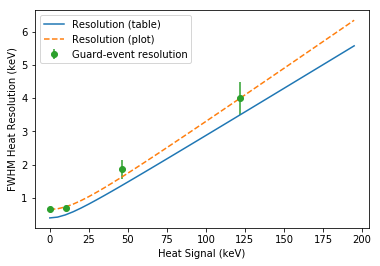

In [7]:
# plot the heat resolution, reproduce fig 2d from 2004 NIMA Edelweiss paper
E_vec = np.arange(0,200,5)
#table, = plt.plot(E_vec, 2.355*heatRes_GGAl10(E_vec), label='Resolution (table)')
#plot, = plt.plot(E_vec, 2.355*heatRes_GGAl10_guard(E_vec), linestyle='--', label='Resolution (plot)')
table, = plt.plot(E_vec, heatRes_GGAl10(E_vec), label='Resolution (table)')
plot, = plt.plot(E_vec, heatRes_GGAl10_guard(E_vec), linestyle='--', label='Resolution (plot)')
data = plt.errorbar(heatRes_data.Energy, heatRes_data.FWHM,yerr=heatRes_data.error,fmt='o', label='Guard-event resolution')
plt.xlabel("Heat Signal (keV)")
plt.ylabel("FWHM Heat Resolution (keV)")
plt.legend(handles=[table, plot, data])

0.019517837540640424
0.02188693429970277
0.03415621569612074
0.03830213502447985


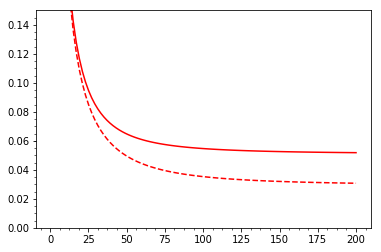

In [8]:
# expect aH to be 0.02 based on fig. 7
# but instead it's 0.009??
sig_gamma_GGA3 = get_sig_gamma_func(1.3, 1.5, 3.1, 0.4, 2.7, 4, 1)
sig_gamma_GGA3_wide = get_sig_gamma_func(1.3, 1.5, 3.1, 0.4, 2.7, 4, 1.75)


# 90% is +/- 1.645*sigma
# FWHM is 2.355*sigma
E_keV_arr = np.linspace(1,200,100)

# plot the central nuclear recoil line
plt.plot(E_keV_arr, sig_gamma_GGA3(E_keV_arr),'r--')
plt.plot(E_keV_arr, sig_gamma_GGA3_wide(E_keV_arr),'r-')

# plot the data-theifed bands
#plt.plot(band_data.x[band_data.x>7.82], band_data.Curve1[band_data.x>7.82], 'b.')
#plt.plot(band_data.x, band_data.curve2, 'b.')

plt.ylim(0,0.15)
plt.minorticks_on()

In [9]:
# get_sig_gamma_func(FWHM_center, FWHM_guard, FWHM122_ion, FWHM0_heat, FWHM122_heat, V, aH_stretch)
# increasing FWHM0_heat makes the fit better near 20 keV, e.g. from 1.3 to 2.3 for GGA1
# increasing V makes the 20 keV region fit better but makes the high-energy region overshoot the data
# increasing FWHM122_heat increases the width at higher energies and has no impact on lower energies
# increasing aH_stretch increases the width at higher energies and has no impact on lower energies
# if I use the parameters for GeAl6 it seems to fit the bands much better, unless the actual voltage for GeAl6 is used
#sig_gamma_GGA1 = get_sig_gamma_func(1.3, 1.3, 2.8, 1.3, 3.5, 4, 1)
sig_gamma_GGA1 = get_sig_gamma_func(2, 1.4, 2.8, 2.2, 3.5, 6.34, 1.3)
sig_gamma_GGA1_a = get_sig_gamma_func(1.3, 1.3, 2.8, 1.3, 3.5, 4, 1.5)

0.014610411443477632
0.029006319451575505
0.02596562960894616
0.039954287235914564


In [18]:
band_data = pd.read_csv("edelweiss_bands_GGA1.csv")
print (band_data.head(5))

# path 0: 68.75 keV inelastic scattering
# path 1: average NR line
# path 2: 13.26 keV inelastic
# path 3: ionization threshold
# path 4: lower nuclear recoil band
# path 5: upper nuclear recoil band
# path 6: upper and lower electron recoil band
band_data_svg = pd.read_csv("edelweiss_band_GGA1_curveData.txt", skiprows=1, header=None, delim_whitespace=True)
print (band_data_svg.head(5))
list(band_data_svg.columns.values)

       x   Curve1   curve2   curve3   curve4
0  1.667 -6.44581 -0.08957  1.49300 -0.64478
1  1.802 -6.06069 -0.08789  1.44296 -0.62392
2  1.804 -6.05415 -0.08786  1.46798 -0.62356
3  1.938 -5.68168 -0.08613  1.41795 -0.60321
4  2.075 -5.31531 -0.08430  1.39293 -0.58303
        0         1        2         3        4         5        6        7   \
0  69.4986  0.991839  1.02904  0.159922  14.2519  0.944224  2.10350  1.49896   
1  69.8626  0.987244  1.31515  0.167136  14.3933  0.936084  2.11548  1.48548   
2  70.2266  0.982648  1.60126  0.174349  14.5347  0.927944  2.12746  1.47200   
3  70.5907  0.978053  2.05730  0.181087  14.6761  0.919803  2.13943  1.45851   
4  70.9944  0.973552  2.45114  0.187750  14.8725  0.911724  2.15141  1.44503   

        8         9        10       11        12       13  
0  11.0197 -0.002028  1.89725  1.50072   9.99176  1.50730  
1  11.3235  0.005082  1.92804  1.48860  10.39770  1.48881  
2  11.6309  0.012183  1.95883  1.47648  10.78450  1.47030  
3  11.993

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

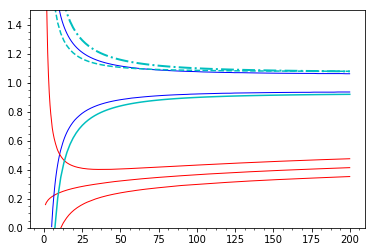

In [35]:
# 90% is +/- 1.645*sigma
# FWHM is 2.355*sigma

E_keV_arr = np.linspace(1,200,100)

# plot the central nuclear recoil line
plt.plot(band_data_svg[2], band_data_svg[3], 'r', linewidth=1)
#plt.plot(E_keV_arr, Q_avg(E_keV_arr),'r--')

# plot the data-theifed bands
#plt.plot(band_data.x[band_data.x>7.82], band_data.Curve1[band_data.x>7.82], 'b.')
#plt.plot(band_data.x, band_data.curve2, 'b.')
plt.plot(band_data_svg[12][band_data_svg[13]>1], band_data_svg[13][band_data_svg[13]>1], 'b', linewidth=1)
plt.plot(band_data_svg[12][band_data_svg[13]<1], band_data_svg[13][band_data_svg[13]<1], 'b', linewidth=1)

#plt.plot(band_data.x, band_data.curve3, 'r.')
#plt.plot(band_data.x, band_data.curve4, 'r.')
plt.plot(band_data_svg[8], band_data_svg[9], 'r', linewidth=1)
plt.plot(band_data_svg[10], band_data_svg[11], 'r', linewidth=1)

# plot the ionization bands
plt.plot(E_keV_arr, 1+1.645*sig_gamma_GGA1(E_keV_arr), 'c-.', linewidth=2)
plt.plot(E_keV_arr, 1-1.645*sig_gamma_GGA1(E_keV_arr), 'c-')
plt.plot(E_keV_arr, 1+1.645*sig_gamma_GGA1_a(E_keV_arr), 'c--')

plt.ylim(0,1.5)
plt.minorticks_on()
#plt.grid(True)